In [106]:
import sys 
sys.path.append('../MIDSEMS/M1/M1/env')

from random_maze import randomMaze

In [107]:
import gym
import numpy as np
from numpy import random
from numpy.core.fromnumeric import argmax
from math import exp,log,sqrt
import matplotlib.pyplot as plt 

# problem 3, Q1

Generated trajecory, self - explanatory

In [245]:
def generateTrajectory(env,pi,maxSteps):
    timesteps = 0
    ep = []
    ini_state = [2,0]
    state = 8
    while state != 3 and state != 7:
        action = pi[ini_state[0]][ini_state[1]]
        next_state,reward,st,env_action = rme.step(action,ini_state)
        ep.append((state,action,env_action,reward,next_state))
        timesteps += 1
     
#     print("State:",state,"Action:",action,"Environment Action:",env_action,"Next State:",next_state,"Reward:",reward)
        state = next_state
        ini_state = st
        if timesteps == maxSteps:
            if state!= 3 and state!= 7:
                ep.clear()
            break
    env.reset()
    return ep

# Testing Generate Trajectory

In [246]:
print("Testing the generateTrajectory function:")
np.random.seed(3)
rme = randomMaze()
pi = [[1,1,1,0],[0,0,0,0],[0,3,0,3]]
ep = generateTrajectory(rme,pi,20)
if (len(ep)):
    print("The state terminates")
    for i in range(len(ep)):
        print("Starting State:",ep[i][0],"Action Taken",ep[i][1],"Resulting Action:",ep[i][2],"Reward:",ep[i][3],"Next State:",ep[i][4])
    
else:
    print("The function does not terminate")
np.random.seed(3)
ep = generateTrajectory(rme,pi,5)
if (len(ep)):
    print("The state terminates")
    for i in range(len(ep)):
        print("Starting State:",ep[i][0],"Action Taken",ep[i][1],"Resulting Action:",ep[i][2],"Reward:",ep[i][3],"Next State:",ep[i][4])
    
else:
    print("The function does not terminate")

Testing the generateTrajectory function:
The state terminates
Starting State: 8 Action Taken 0 Resulting Action: 0 Reward: -0.04 Next State: 4
Starting State: 4 Action Taken 0 Resulting Action: 0 Reward: -0.04 Next State: 0
Starting State: 0 Action Taken 1 Resulting Action: 1 Reward: -0.04 Next State: 1
Starting State: 1 Action Taken 1 Resulting Action: 1 Reward: -0.04 Next State: 2
Starting State: 2 Action Taken 1 Resulting Action: 0 Reward: -0.04 Next State: 2
Starting State: 2 Action Taken 1 Resulting Action: 0 Reward: -0.04 Next State: 2
Starting State: 2 Action Taken 1 Resulting Action: 1 Reward: 1 Next State: 3
The function does not terminate


# Q2.

Alpha decay with both linear and exponential values

In [110]:
def decayAlpha(initialValue, finalValue, maxSteps, decayTypes):
    e = 0
    x = []
    k = log(initialValue/finalValue)/(maxSteps-1)
    while e<maxSteps:
        if decayTypes=="linear":
            x.append(initialValue-(e)*(initialValue-finalValue)/(maxSteps-1))
        else:
            x.append(initialValue*exp(-(e)*k))
        e+=1
    return x

# Testing Alpha Decay

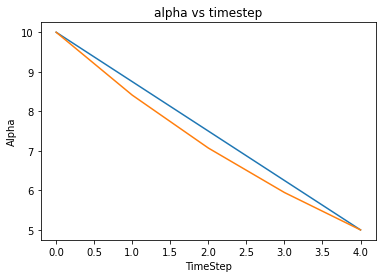

In [111]:
a = decayAlpha(10,5,5,"linear")
a2 = decayAlpha(10,5,5,"exp")
x = np.arange(5)
plt.plot(x,a)
plt.plot(x,a2)
plt.xlabel("TimeStep")
plt.ylabel("Alpha")
plt.title("alpha vs timestep")
plt.show()
plt.close()

# Monte Carlo - EVMC and FVMC

In [247]:
def monteCarlo(env,pi,gamma,alpha,maxSteps,noEpisodes,firstVisit):
    v = np.zeros((3,4))
    v_r = np.zeros((noEpisodes,3,4))
    Gt = np.zeros(noEpisodes)
    for e in range(noEpisodes):
        env.reset()
        t = generateTrajectory(env,pi,maxSteps)
        visited = np.zeros((3,4))
        
        for i in range(len(t)):
            s = t[i][0]
            # print(s)
            r = t[i][3]
            if visited[s//4][s%4] and firstVisit:
                continue
            G = 0
            for j in range(i,len(t)):
                G += gamma*t[j][3]
            if s==8:
                Gt[e] = G
            v[s//4][s%4] = v[s//4][s%4] + alpha[e]*(G-v[s//4][s%4])
            visited[s//4][s%4] = 1
        
        v_r[e] = v
        
    return v,v_r,Gt

# Temporal Difference

In [248]:
def temporalDifference(env,pi,gamma,alpha,noEpisodes):
    v = np.zeros((3,4))
    v_r = np.zeros((noEpisodes,3,4))
    Gt = np.zeros(noEpisodes)
    for e in range(noEpisodes):
        s = 8
        done = False
        env.reset()
        while not done:
            a = pi[s//4][s%4]
            next_state,reward,st,env_action = env.step(a,[s//4,s%4])
            td_target = reward
            if next_state==3 or next_state==7:
                done = True
            if not done:
                td_target = td_target + gamma*v[next_state//4][next_state%4]
                if s==8:
                    Gt[e] = td_target
            td_error = td_target-v[s//4][s%4]
            v[s//4][s%4] = v[s//4][s%4] + alpha[e]*td_error
            s = next_state
        v_r[e] = v
    return v,v_r,Gt 

# Helper function for n-step TD

Generated n step trajectory

In [249]:
def generateNStepTrajectory(env,pi,state,maxSteps):
    timesteps = 0
    ep = []
    ini_state = [state//4,state%4]
    done = False
    while state != 3 and state != 7:
        action = pi[ini_state[0]][ini_state[1]]
        next_state,reward,st,env_action = rme.step(action,ini_state)
        ep.append((state,action,env_action,reward,next_state))
        timesteps += 1
     
#     print("State:",state,"Action:",action,"Environment Action:",env_action,"Next State:",next_state,"Reward:",reward)
        state = next_state
        ini_state = st
        if timesteps == maxSteps:
            break
#     env.reset()
    if state==3 or state==7:
        done = True
    return ep,state,done

# Returns the partial gains of the function

the loop is in the reverses order to compensate for the gamma baeing multiplied more times in the later stages

In [250]:
def calculateReturn(gamma,path,n):
    g = 0
    for i in range(len(path)-1,-1,-1):
        g = gamma*g
        g+=path[i][3]
    return g

# n-step TD

Faults in the code in the lecture slide was corrected, the state is now updated in this code after n-Steps, the discount is taken care in this code by taking appropriate power of gamma

In [216]:
def nstepTDprediction(env,pi,gamma,alpha,n,episodes):
    v = np.zeros((3,4))
    v_r = np.zeros((episodes,3,4))
    
    for e in range(episodes):
        alp = alpha[e]
        s = 8
        path = []
        done = False
        cnt = 0
        env.reset()
        while not done and path is not None:
            path,next_s,done = generateNStepTrajectory(env,pi,s,n)
#             print(path)
            g = calculateReturn(gamma,path,n)
            if not done:
                target = g+pow(gamma,n)*v[next_s//4][next_s%4]
                target = target*pow(gamma,3*cnt)
            ntd_error = target - v[s//4][s%4]
            v[s//4][s%4] = v[s//4][s%4]+alp*ntd_error
            if len(path)==1 and done:
                path = None
            s = next_s
            cnt += 1
        v_r[e] = v
        env.reset()
    return v_r

# TD Lambda implementation

In [251]:
def TDLambda(env,pi,gamma,alpha,lamda,episodes):
    v = np.zeros((3,4))
    v_r = np.zeros((episodes,3,4))
    E = np.zeros((3,4))
    for e in range(episodes):
        alp = alpha[e]
        s = 8
        done = False
        while not done:
            a = pi[s//4][s%4]
            next_s,reward,st,env_action = env.step(a,[s//4,s%4])
            td_target = reward
            if next_s==3 or next_s==7:
                done = True
            if not done:
                td_target += gamma*v[next_s//4][next_s%4]
            td_error = td_target-v[s//4][s%4]
            E[s//4][s%4] += 1
            v = v + alp*td_error*E
            E = gamma*lamda*E
            s = next_s
        v_r[e] = v
    return v_r
                

# generating helper codes for the subsequent graphs

In [252]:
alpha = decayAlpha(0.5,0.01,250,"e")
for i in range(250):
    alpha = np.append(alpha,0.01)

In [253]:
rme = randomMaze()
pi = [[1,1,1,0],[0,0,0,0],[0,3,0,3]]

# MC-FVMC estimates

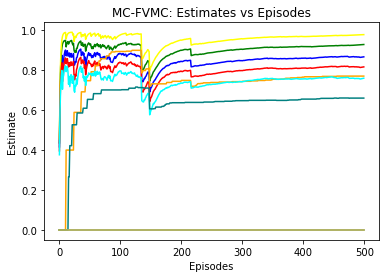

In [254]:
np.random.seed(3)
v,v_r2,Gt1 = monteCarlo(rme,pi,0.99,alpha,1000,500,1)
x = np.arange(0,500)
plt.plot(x,v_r2[:,0,0],color = 'blue')
# plt.plot(x,5/6*np.ones(500),color = 'blue',linestyle = "--")
plt.plot(x,v_r2[:,0,1],color = 'green')
# plt.plot(x,4/6*np.ones(500),color = 'green',linestyle = "--")
plt.plot(x,v_r2[:,0,2],color = 'yellow')
# plt.plot(x,3/6*np.ones(500),color = 'yellow',linestyle = "--")
plt.plot(x,v_r2[:,1,0],color = 'red')
# plt.plot(x,2/6*np.ones(500),color = 'red',linestyle = "--")
plt.plot(x,v_r2[:,1,2],color = 'orange')
# plt.plot(x,1/6*np.ones(500),color = 'orange',linestyle = "--")
plt.plot(x,v_r2[:,2,0],color = 'cyan')
# plt.plot(x,5/6*np.ones(500),color = 'blue',linestyle = "--")
plt.plot(x,v_r2[:,2,1],color = 'teal')
# plt.plot(x,4/6*np.ones(500),color = 'green',linestyle = "--")
plt.plot(x,v_r2[:,2,2],color = 'olivedrab')
# plt.plot(x,3/6*np.ones(500),color = 'yellow',linestyle = "--")
plt.plot(x,v_r2[:,2,3],color = 'darkkhaki')
# plt.plot(x,2/6*np.ones(500),color = 'red',linestyle = "--")
# plt.legend(["v(5)","v(4)","v(3)","v(2)","v(1)"])
plt.xlabel("Episodes")
plt.ylabel("Estimate")
plt.title("MC-FVMC: Estimates vs Episodes")
plt.savefig("new3.pdf")
plt.legend(["0","1","2","4","6","8","9","10","11"], loc = "upper right")

plt.show()
plt.close()

# MC-EVMC Estimates

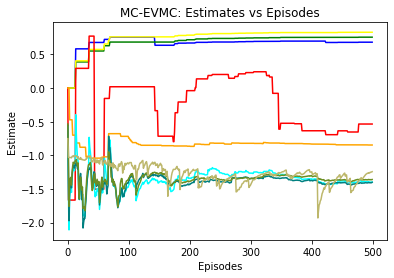

In [255]:
np.random.seed(3)
pi = np.ones((3,4))
v,v_r3,Gt2 = monteCarlo(rme,pi,0.99,alpha,1000,500,0)
x = np.arange(0,500)
plt.plot(x,v_r3[:,0,0],color = 'blue')
# plt.plot(x,5/6*np.ones(500),color = 'blue',linestyle = "--")
plt.plot(x,v_r3[:,0,1],color = 'green')
# plt.plot(x,4/6*np.ones(500),color = 'green',linestyle = "--")
plt.plot(x,v_r3[:,0,2],color = 'yellow')
# plt.plot(x,3/6*np.ones(500),color = 'yellow',linestyle = "--")
plt.plot(x,v_r3[:,1,0],color = 'red')
# plt.plot(x,2/6*np.ones(500),color = 'red',linestyle = "--")
plt.plot(x,v_r3[:,1,2],color = 'orange')
# plt.plot(x,1/6*np.ones(500),color = 'orange',linestyle = "--")
plt.plot(x,v_r3[:,2,0],color = 'cyan')
# plt.plot(x,5/6*np.ones(500),color = 'blue',linestyle = "--")
plt.plot(x,v_r3[:,2,1],color = 'teal')
# plt.plot(x,4/6*np.ones(500),color = 'green',linestyle = "--")
plt.plot(x,v_r3[:,2,2],color = 'olivedrab')
# plt.plot(x,3/6*np.ones(500),color = 'yellow',linestyle = "--")
plt.plot(x,v_r3[:,2,3],color = 'darkkhaki')
# plt.plot(x,2/6*np.ones(500),color = 'red',linestyle = "--")
# plt.legend(["v(5)","v(4)","v(3)","v(2)","v(1)"])
plt.xlabel("Episodes")
plt.ylabel("Estimate")
plt.legend(["0","1","2","4","6","8","9","10","11"], loc = "upper right")

plt.title("MC-EVMC: Estimates vs Episodes")
plt.savefig("new3.pdf")
plt.show()
plt.close()

# Q19

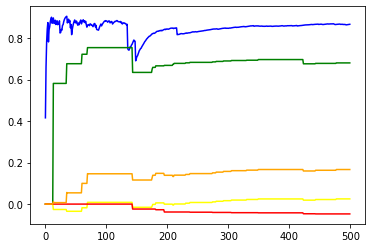

In [276]:
plt.plot(x,v_r2[:,0,0],color = 'blue')
# plt.plot(x,5/6*np.ones(500),color = 'blue',linestyle = "--")
plt.plot(x,v_r3[:,0,0],color = 'green')
# plt.plot(x,4/6*np.ones(500),color = 'green',linestyle = "--")
plt.plot(x,v_r4[:,0,0],color = 'yellow')
# plt.plot(x,3/6*np.ones(500),color = 'yellow',linestyle = "--")
plt.plot(x,v_r5[:,0,0],color = 'red')
# plt.plot(x,2/6*np.ones(500),color = 'red',linestyle = "--")
plt.plot(x,v_r6[:,0,0],color = 'orange')

# TD Estimates

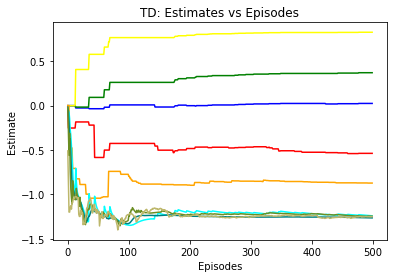

In [256]:
np.random.seed(3)
pi = np.ones((3,4))
v,v_r4,Gt3 = temporalDifference(rme,pi,0.99,alpha,500)
x = np.arange(0,500)
plt.plot(x,v_r4[:,0,0],color = 'blue')
# plt.plot(x,5/6*np.ones(500),color = 'blue',linestyle = "--")
plt.plot(x,v_r4[:,0,1],color = 'green')
# plt.plot(x,4/6*np.ones(500),color = 'green',linestyle = "--")
plt.plot(x,v_r4[:,0,2],color = 'yellow')
# plt.plot(x,3/6*np.ones(500),color = 'yellow',linestyle = "--")
plt.plot(x,v_r4[:,1,0],color = 'red')
# plt.plot(x,2/6*np.ones(500),color = 'red',linestyle = "--")
plt.plot(x,v_r4[:,1,2],color = 'orange')
# plt.plot(x,1/6*np.ones(500),color = 'orange',linestyle = "--")
plt.plot(x,v_r4[:,2,0],color = 'cyan')
# plt.plot(x,5/6*np.ones(500),color = 'blue',linestyle = "--")
plt.plot(x,v_r4[:,2,1],color = 'teal')
# plt.plot(x,4/6*np.ones(500),color = 'green',linestyle = "--")
plt.plot(x,v_r4[:,2,2],color = 'olivedrab')
# plt.plot(x,3/6*np.ones(500),color = 'yellow',linestyle = "--")
plt.plot(x,v_r4[:,2,3],color = 'darkkhaki')
# plt.plot(x,2/6*np.ones(500),color = 'red',linestyle = "--")
# plt.legend(["v(5)","v(4)","v(3)","v(2)","v(1)"])
plt.xlabel("Episodes")
plt.ylabel("Estimate")
plt.legend(["0","1","2","4","6","8","9","10","11"], loc = "upper right")

plt.title("TD: Estimates vs Episodes")
plt.savefig("new3.pdf")
plt.show()
plt.close()

# n-steps TD

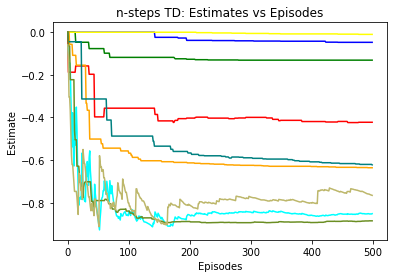

In [257]:
np.random.seed(3)
pi = np.ones((3,4))
v_r5 = nstepTDprediction(rme,pi,0.99,alpha,3,500)
x = np.arange(0,500)
plt.plot(x,v_r5[:,0,0],color = 'blue')
# plt.plot(x,5/6*np.ones(500),color = 'blue',linestyle = "--")
plt.plot(x,v_r5[:,0,1],color = 'green')
# plt.plot(x,4/6*np.ones(500),color = 'green',linestyle = "--")
plt.plot(x,v_r5[:,0,2],color = 'yellow')
# plt.plot(x,3/6*np.ones(500),color = 'yellow',linestyle = "--")
plt.plot(x,v_r5[:,1,0],color = 'red')
# plt.plot(x,2/6*np.ones(500),color = 'red',linestyle = "--")
plt.plot(x,v_r5[:,1,2],color = 'orange')
# plt.plot(x,1/6*np.ones(500),color = 'orange',linestyle = "--")
plt.plot(x,v_r5[:,2,0],color = 'cyan')
# plt.plot(x,5/6*np.ones(500),color = 'blue',linestyle = "--")
plt.plot(x,v_r5[:,2,1],color = 'teal')
# plt.plot(x,4/6*np.ones(500),color = 'green',linestyle = "--")
plt.plot(x,v_r5[:,2,2],color = 'olivedrab')
# plt.plot(x,3/6*np.ones(500),color = 'yellow',linestyle = "--")
plt.plot(x,v_r5[:,2,3],color = 'darkkhaki')
# plt.plot(x,2/6*np.ones(500),color = 'red',linestyle = "--")
# plt.legend(["v(5)","v(4)","v(3)","v(2)","v(1)"])
plt.xlabel("Episodes")
plt.ylabel("Estimate")
plt.legend(["0","1","2","4","6","8","9","10","11"], loc = "upper right")

plt.title("n-steps TD: Estimates vs Episodes")
plt.savefig("new3.pdf")
plt.show()
plt.close()

# TD Lambda estimates

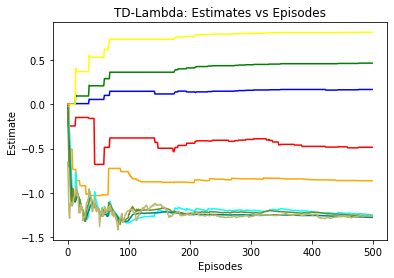

In [259]:
np.random.seed(3)
pi = np.ones((3,4))
v_r6 = TDLambda(rme,pi,0.99,alpha,0.3,500)
x = np.arange(0,500)
plt.plot(x,v_r6[:,0,0],color = 'blue')
# plt.plot(x,5/6*np.ones(500),color = 'blue',linestyle = "--")
plt.plot(x,v_r6[:,0,1],color = 'green')
# plt.plot(x,4/6*np.ones(500),color = 'green',linestyle = "--")
plt.plot(x,v_r6[:,0,2],color = 'yellow')
# plt.plot(x,3/6*np.ones(500),color = 'yellow',linestyle = "--")
plt.plot(x,v_r6[:,1,0],color = 'red')
# plt.plot(x,2/6*np.ones(500),color = 'red',linestyle = "--")
plt.plot(x,v_r6[:,1,2],color = 'orange')
# plt.plot(x,1/6*np.ones(500),color = 'orange',linestyle = "--")
plt.plot(x,v_r6[:,2,0],color = 'cyan')
# plt.plot(x,5/6*np.ones(500),color = 'blue',linestyle = "--")
plt.plot(x,v_r6[:,2,1],color = 'teal')
# plt.plot(x,4/6*np.ones(500),color = 'green',linestyle = "--")
plt.plot(x,v_r6[:,2,2],color = 'olivedrab')
# plt.plot(x,3/6*np.ones(500),color = 'yellow',linestyle = "--")
plt.plot(x,v_r6[:,2,3],color = 'darkkhaki')
# plt.plot(x,2/6*np.ones(500),color = 'red',linestyle = "--")
# plt.legend(["v(5)","v(4)","v(3)","v(2)","v(1)"])
plt.xlabel("Episodes")
plt.ylabel("Estimate")
plt.legend(["0","1","2","4","6","8","9","10","11"], loc = "upper right")

plt.title("TD-Lambda: Estimates vs Episodes")
plt.savefig("new3.pdf")
plt.show()
plt.close()

# log scale MC-FVMC

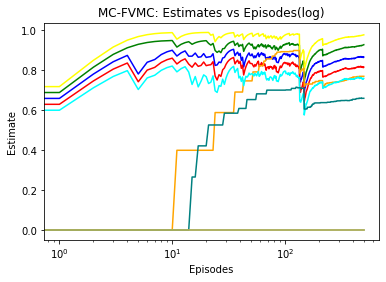

In [260]:
plt.plot(x,v_r2[:,0,0],color = 'blue')
# plt.plot(x,5/6*np.ones(500),color = 'blue',linestyle = "--")
plt.plot(x,v_r2[:,0,1],color = 'green')
# plt.plot(x,4/6*np.ones(500),color = 'green',linestyle = "--")
plt.plot(x,v_r2[:,0,2],color = 'yellow')
# plt.plot(x,3/6*np.ones(500),color = 'yellow',linestyle = "--")
plt.plot(x,v_r2[:,1,0],color = 'red')
# plt.plot(x,2/6*np.ones(500),color = 'red',linestyle = "--")
plt.plot(x,v_r2[:,1,2],color = 'orange')
# plt.plot(x,1/6*np.ones(500),color = 'orange',linestyle = "--")
plt.plot(x,v_r2[:,2,0],color = 'cyan')
# plt.plot(x,5/6*np.ones(500),color = 'blue',linestyle = "--")
plt.plot(x,v_r2[:,2,1],color = 'teal')
# plt.plot(x,4/6*np.ones(500),color = 'green',linestyle = "--")
plt.plot(x,v_r2[:,2,2],color = 'olivedrab')
# plt.plot(x,3/6*np.ones(500),color = 'yellow',linestyle = "--")
plt.plot(x,v_r2[:,2,3],color = 'darkkhaki')
# plt.plot(x,2/6*np.ones(500),color = 'red',linestyle = "--")
# plt.legend(["v(5)","v(4)","v(3)","v(2)","v(1)"])
plt.xscale("log")
plt.xlabel("Episodes")
plt.legend(["0","1","2","4","6","8","9","10","11"], loc = "upper right")

plt.ylabel("Estimate")
plt.title("MC-FVMC: Estimates vs Episodes(log)")
plt.savefig("new3.pdf")
plt.show()
plt.close()

# log scale MC-EVMC

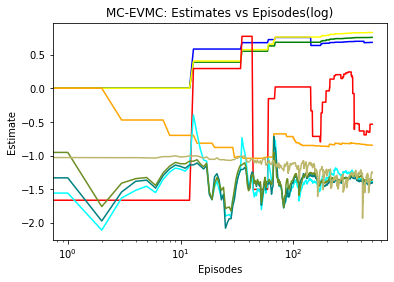

In [261]:
x = np.arange(0,500)
plt.plot(x,v_r3[:,0,0],color = 'blue')
# plt.plot(x,5/6*np.ones(500),color = 'blue',linestyle = "--")
plt.plot(x,v_r3[:,0,1],color = 'green')
# plt.plot(x,4/6*np.ones(500),color = 'green',linestyle = "--")
plt.plot(x,v_r3[:,0,2],color = 'yellow')
# plt.plot(x,3/6*np.ones(500),color = 'yellow',linestyle = "--")
plt.plot(x,v_r3[:,1,0],color = 'red')
# plt.plot(x,2/6*np.ones(500),color = 'red',linestyle = "--")
plt.plot(x,v_r3[:,1,2],color = 'orange')
# plt.plot(x,1/6*np.ones(500),color = 'orange',linestyle = "--")
plt.plot(x,v_r3[:,2,0],color = 'cyan')
# plt.plot(x,5/6*np.ones(500),color = 'blue',linestyle = "--")
plt.plot(x,v_r3[:,2,1],color = 'teal')
# plt.plot(x,4/6*np.ones(500),color = 'green',linestyle = "--")
plt.plot(x,v_r3[:,2,2],color = 'olivedrab')
# plt.plot(x,3/6*np.ones(500),color = 'yellow',linestyle = "--")
plt.plot(x,v_r3[:,2,3],color = 'darkkhaki')
# plt.plot(x,2/6*np.ones(500),color = 'red',linestyle = "--")
# plt.legend(["v(5)","v(4)","v(3)","v(2)","v(1)"])
plt.xscale("log")
plt.xlabel("Episodes")
plt.ylabel("Estimate")
plt.legend(["0","1","2","4","6","8","9","10","11"], loc = "upper right")

plt.title("MC-EVMC: Estimates vs Episodes(log)")
plt.savefig("new3.pdf")
plt.show()
plt.close()

# log scale TD

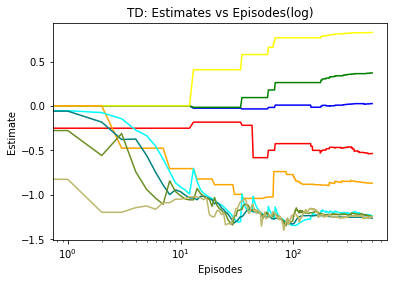

In [262]:
x = np.arange(0,500)
plt.plot(x,v_r4[:,0,0],color = 'blue')
# plt.plot(x,5/6*np.ones(500),color = 'blue',linestyle = "--")
plt.plot(x,v_r4[:,0,1],color = 'green')
# plt.plot(x,4/6*np.ones(500),color = 'green',linestyle = "--")
plt.plot(x,v_r4[:,0,2],color = 'yellow')
# plt.plot(x,3/6*np.ones(500),color = 'yellow',linestyle = "--")
plt.plot(x,v_r4[:,1,0],color = 'red')
# plt.plot(x,2/6*np.ones(500),color = 'red',linestyle = "--")
plt.plot(x,v_r4[:,1,2],color = 'orange')
# plt.plot(x,1/6*np.ones(500),color = 'orange',linestyle = "--")
plt.plot(x,v_r4[:,2,0],color = 'cyan')
# plt.plot(x,5/6*np.ones(500),color = 'blue',linestyle = "--")
plt.plot(x,v_r4[:,2,1],color = 'teal')
# plt.plot(x,4/6*np.ones(500),color = 'green',linestyle = "--")
plt.plot(x,v_r4[:,2,2],color = 'olivedrab')
# plt.plot(x,3/6*np.ones(500),color = 'yellow',linestyle = "--")
plt.plot(x,v_r4[:,2,3],color = 'darkkhaki')
# plt.plot(x,2/6*np.ones(500),color = 'red',linestyle = "--")
# plt.legend(["v(5)","v(4)","v(3)","v(2)","v(1)"])
plt.xscale("log")
plt.xlabel("Episodes")
plt.ylabel("Estimate")
plt.legend(["0","1","2","4","6","8","9","10","11"], loc = "upper right")

plt.title("TD: Estimates vs Episodes(log)")
plt.savefig("new3.pdf")
plt.show()
plt.close()

# log scale n-step TD

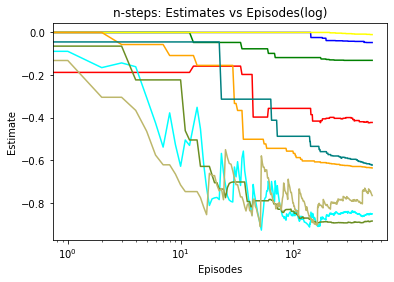

In [264]:
x = np.arange(0,500)
plt.plot(x,v_r5[:,0,0],color = 'blue')
# plt.plot(x,5/6*np.ones(500),color = 'blue',linestyle = "--")
plt.plot(x,v_r5[:,0,1],color = 'green')
# plt.plot(x,4/6*np.ones(500),color = 'green',linestyle = "--")
plt.plot(x,v_r5[:,0,2],color = 'yellow')
# plt.plot(x,3/6*np.ones(500),color = 'yellow',linestyle = "--")
plt.plot(x,v_r5[:,1,0],color = 'red')
# plt.plot(x,2/6*np.ones(500),color = 'red',linestyle = "--")
plt.plot(x,v_r5[:,1,2],color = 'orange')
# plt.plot(x,1/6*np.ones(500),color = 'orange',linestyle = "--")
plt.plot(x,v_r5[:,2,0],color = 'cyan')
# plt.plot(x,5/6*np.ones(500),color = 'blue',linestyle = "--")
plt.plot(x,v_r5[:,2,1],color = 'teal')
# plt.plot(x,4/6*np.ones(500),color = 'green',linestyle = "--")
plt.plot(x,v_r5[:,2,2],color = 'olivedrab')
# plt.plot(x,3/6*np.ones(500),color = 'yellow',linestyle = "--")
plt.plot(x,v_r5[:,2,3],color = 'darkkhaki')
# plt.plot(x,2/6*np.ones(500),color = 'red',linestyle = "--")
# plt.legend(["v(5)","v(4)","v(3)","v(2)","v(1)"])
plt.xscale("log")
plt.xlabel("Episodes")
plt.ylabel("Estimate")
plt.title("n-steps: Estimates vs Episodes(log)")
plt.legend(["0","1","2","4","6","8","9","10","11"], loc = "upper right")

plt.savefig("new3.pdf")
plt.show()
plt.close()

# log scale TD lambda

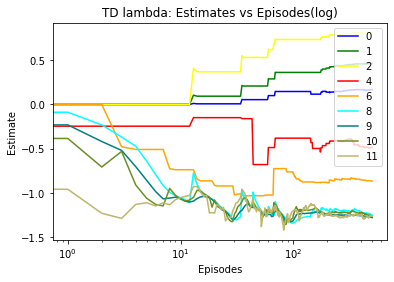

In [275]:
x = np.arange(0,500)
plt.plot(x,v_r6[:,0,0],color = 'blue')
# plt.plot(x,5/6*np.ones(500),color = 'blue',linestyle = "--")
plt.plot(x,v_r6[:,0,1],color = 'green')
# plt.plot(x,4/6*np.ones(500),color = 'green',linestyle = "--")
plt.plot(x,v_r6[:,0,2],color = 'yellow')
# plt.plot(x,3/6*np.ones(500),color = 'yellow',linestyle = "--")
plt.plot(x,v_r6[:,1,0],color = 'red')
# plt.plot(x,2/6*np.ones(500),color = 'red',linestyle = "--")
plt.plot(x,v_r6[:,1,2],color = 'orange')
# plt.plot(x,1/6*np.ones(500),color = 'orange',linestyle = "--")
plt.plot(x,v_r6[:,2,0],color = 'cyan')
# plt.plot(x,5/6*np.ones(500),color = 'blue',linestyle = "--")
plt.plot(x,v_r6[:,2,1],color = 'teal')
# plt.plot(x,4/6*np.ones(500),color = 'green',linestyle = "--")
plt.plot(x,v_r6[:,2,2],color = 'olivedrab')
# plt.plot(x,3/6*np.ones(500),color = 'yellow',linestyle = "--")
plt.plot(x,v_r6[:,2,3],color = 'darkkhaki')
# plt.plot(x,2/6*np.ones(500),color = 'red',linestyle = "--")
# plt.legend(["v(5)","v(4)","v(3)","v(2)","v(1)"])
plt.xscale("log")
plt.xlabel("Episodes")
plt.ylabel("Estimate")
plt.legend(["0","1","2","4","6","8","9","10","11"], loc = "upper right")
plt.title("TD lambda: Estimates vs Episodes(log)")
plt.savefig("new3.pdf")
plt.show()
plt.close()

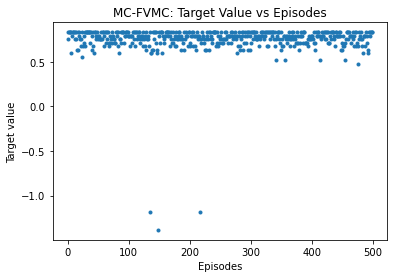

In [269]:
plt.plot(x,Gt1,'.')
# plt.plot(x,3/6*np.ones(500),'--')
plt.savefig("new7.pdf")
plt.xlabel("Episodes")
plt.ylabel("Target value")
plt.title("MC-FVMC: Target Value vs Episodes")
plt.show()
plt.close()

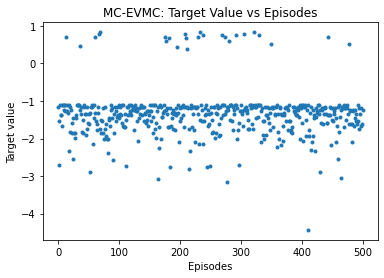

In [270]:
plt.plot(x,Gt2,'.')
# plt.plot(x,3/6*np.ones(500),'--')
plt.savefig("new7.pdf")
plt.xlabel("Episodes")
plt.ylabel("Target value")
plt.title("MC-EVMC: Target Value vs Episodes")
plt.show()
plt.close()

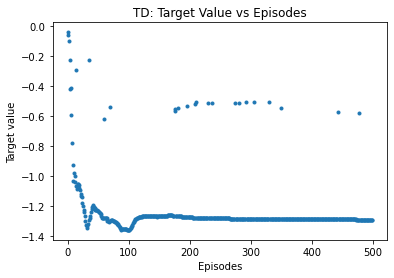

In [271]:
plt.plot(x,Gt3,'.')
# plt.plot(x,3/6*np.ones(500),'--')
plt.savefig("new7.pdf")
plt.xlabel("Episodes")
plt.ylabel("Target value")
plt.title("TD: Target Value vs Episodes")
plt.show()
plt.close()